In [1]:
#TODO: split as two stage training, 1) Interpolation stage 2) froze encoder and decoder update GRN paramters and Kinetic parameters.
from regvelovi import REGVELOVI

Global seed set to 0
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [3]:
scv.set_figure_params()

In [4]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [5]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [6]:
adata.uns["skeleton"].shape

(280, 280)

In [7]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
adata.layers["Ms"].max()

39747.324

In [10]:
adata.X = np.log1p(adata.X.copy())

In [11]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [272]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [273]:
W = torch.ones(W.shape)

In [274]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,lam=100)
#reg_vae_0_0001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.0001)
#reg_vae_0_001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.001)
#reg_vae_0_01 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.01)
#reg_vae_0_1 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.1)

In [275]:
reg_vae.module.v_encoder.grn.data[reg_vae.module.v_encoder.grn.data == 1] = 0

In [276]:
reg_vae.module.v_encoder.grn.data

tensor([[-0.7480, -0.7785, -0.6988,  ...,  0.0215,  0.0174,  0.0176],
        [-0.7603, -0.7980, -0.7035,  ...,  0.0256,  0.0248,  0.0222],
        [ 0.7320,  0.7771,  0.6723,  ..., -0.0875, -0.0794, -0.0794],
        ...,
        [-0.8507, -0.8199, -0.8559,  ...,  0.0234,  0.0215,  0.0182],
        [ 0.1686,  0.1914,  0.1770,  ..., -0.3571, -0.3257, -0.3338],
        [ 0.0454,  0.0865,  0.0711,  ...,  0.0346,  0.0263,  0.0255]])

In [277]:
torch.nn.init.normal_(reg_vae.module.v_encoder.grn.data)

tensor([[ 1.3294, -2.5432, -1.8126,  ...,  1.1036,  0.5293, -1.2225],
        [ 0.2271, -1.9782, -0.3126,  ..., -0.1496, -0.5012,  0.2082],
        [ 0.0852, -0.2110,  0.5515,  ..., -1.1339, -1.2568,  1.9815],
        ...,
        [ 0.0615, -0.3764,  1.1542,  ..., -0.5478, -0.0601,  0.4801],
        [ 0.3991, -0.7604, -0.8269,  ..., -0.6638, -1.4477, -0.2326],
        [ 0.5715,  1.8567, -0.7052,  ..., -0.7836, -0.1842, -1.4051]])

In [278]:
coef = np.array(reg_vae.module.v_encoder.grn.data).ravel()
coef = coef[coef!=0]
coef = np.abs(coef)
coef = pd.DataFrame({"coef":coef})

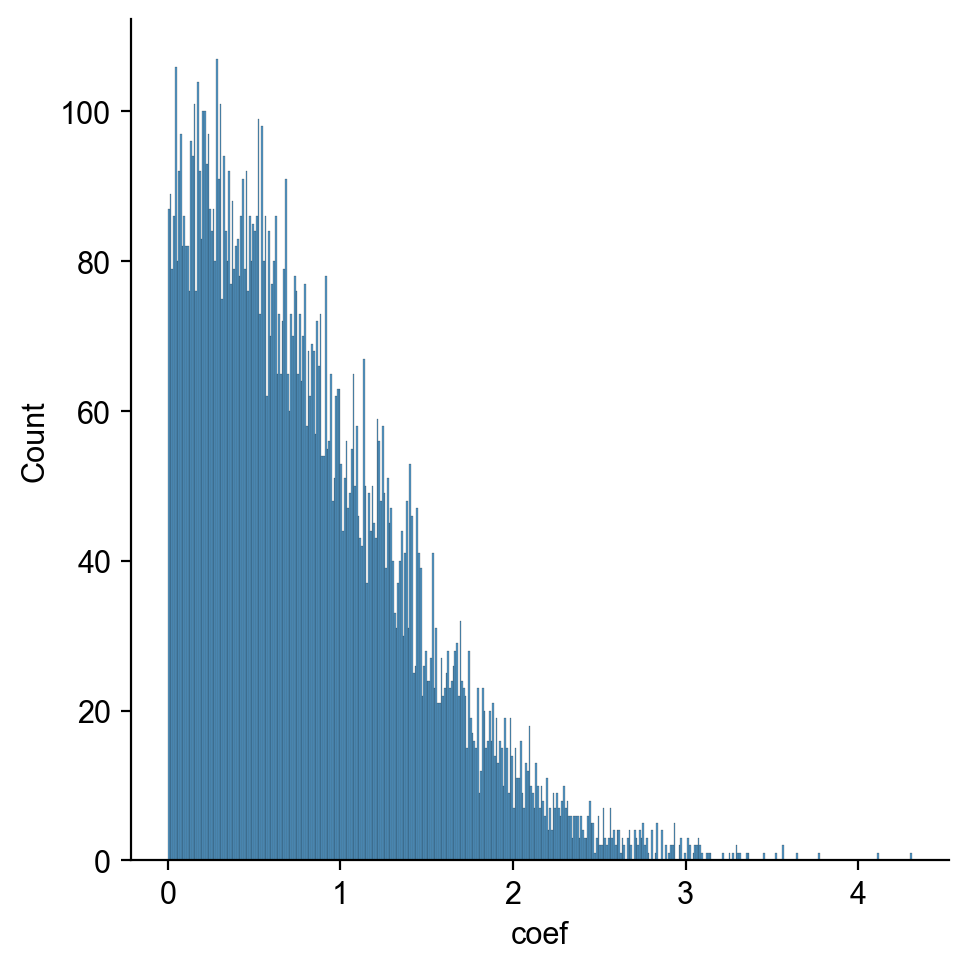

In [279]:
import seaborn as sns
sns.displot(coef, x="coef", binwidth=0.01)

In [280]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [281]:
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_0001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_01.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_1.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [282]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [283]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.2837, 0.3349, 0.4678, 0.0175, 0.4040, 0.3680, 0.4183, 0.3693, 0.3043,
        0.4052, 0.4751, 0.4462, 0.4470, 0.4189, 0.4169, 0.5017, 0.4129, 0.4602,
        0.4169, 0.4801, 0.4721, 0.4369, 0.4919, 0.3943, 0.4950, 0.4681, 0.4105,
        0.4673, 0.4862, 0.4699, 0.4875, 0.4375, 0.2296, 0.4422, 0.3303, 0.5031,
        0.3417, 0.4225, 0.3829, 0.3684, 0.4063, 0.3868, 0.4212, 0.4071, 0.4460,
        0.4173, 0.4596, 0.3101, 0.4275, 0.3168, 0.4852, 0.4858, 0.3787, 0.5065,
        0.4598, 0.4485, 0.4762, 0.5033, 0.3864, 0.4375, 0.2525, 0.3609, 0.4121,
        0.2830, 0.2591, 0.4056, 0.4220, 0.4145, 0.4183, 0.4791, 0.4869, 0.4208,
        0.3835, 0.3845, 0.4808, 0.2246, 0.4352, 0.4272, 0.4049, 0.2792, 0.2199,
        0.2697, 0.4384, 0.2978, 0.4583, 0.3149, 0.4215, 0.2221, 0.3554, 0.1695,
        0.4504, 0.3040, 0.4098, 0.4145, 0.4269, 0.3463, 0.4876, 0.4190, 0.2121,
        0.2435, 0.1957, 0.2750, 0.3196, 0.2718, 0.4824, 0.3453, 0.4284, 0.2497,
        0.4257, 0.

In [284]:
reg_vae.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_0001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_01.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_1.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model is in pretraining stage...
Epoch 369/500:  74%|████████████████████████████████████▏            | 369/500 [06:14<02:13,  1.02s/it, loss=-444, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 0.267. Signaling Trainer to stop.


In [218]:
def GRN_transform(net):
    sign_net = torch.sign(net)
    net_weight = torch.abs(net)
    net_weight = torch.matmul(torch.diag(1 / net_weight.sum(1)),net_weight)
    net = sign_net * net_weight
    return net

In [189]:
reg_vae_tuning = REGVELOVI.load_pretrain_model(adata,reg_vae,freeze_grn = False,freeze_kinetic_params = True,freeze_rbf_params = True,freeze_expression=True,freeze_time_decoder=True)

In [190]:
reg_vae_tuning.train(max_epochs=200,lr=0.0001,optimizer = "AdamW",weight_decay = 0)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model is in refining stage...
Epoch 85/200:  42%|█████████████████████▋                             | 85/200 [01:10<01:34,  1.21it/s, loss=-232, v_num=1]
Monitored metric validation_loss did not improve in the last 45 records. Best score: -231.210. Signaling Trainer to stop.


In [265]:
reg_vae.module.lamba

10

In [426]:
for k,par in reg_vae_tuning.module.named_parameters():
    print(k+" "+str(par.requires_grad))

switch_time_unconstr False
gamma_mean_unconstr False
beta_mean_unconstr False
alpha_unconstr False
alpha_1_unconstr False
scale_unconstr_targets False
z_encoder.encoder.fc_layers.Layer 0.0.weight False
z_encoder.encoder.fc_layers.Layer 0.0.bias False
z_encoder.encoder.fc_layers.Layer 0.1.weight False
z_encoder.encoder.fc_layers.Layer 0.1.bias False
z_encoder.mean_encoder.weight False
z_encoder.mean_encoder.bias False
z_encoder.var_encoder.weight False
z_encoder.var_encoder.bias False
decoder.linear_scaling_tau False
decoder.linear_scaling_tau_intercept False
decoder.rho_first_decoder.fc_layers.Layer 0.0.weight False
decoder.rho_first_decoder.fc_layers.Layer 0.0.bias False
decoder.rho_first_decoder.fc_layers.Layer 0.1.weight False
decoder.rho_first_decoder.fc_layers.Layer 0.1.bias False
decoder.pi_first_decoder.fc_layers.Layer 0.0.weight False
decoder.pi_first_decoder.fc_layers.Layer 0.0.bias False
decoder.pi_first_decoder.fc_layers.Layer 0.1.weight False
decoder.pi_first_decoder.fc_lay

In [427]:
reg_vae_tuning.module.v_encoder.gamma_mean_unconstr

Parameter containing:
tensor([-1.6810, -1.8000, -4.7933, -1.6264, -1.5476, -1.5197, -1.5531, -1.0916,
        -0.8585, -0.9195, -0.7765, -1.0274, -0.8916, -1.0698, -0.7902, -0.5445,
        -0.8976, -0.7349, -0.7769, -0.7507, -0.8469, -0.6866, -0.7746, -0.7995,
        -0.8045, -0.8610, -0.7964, -0.7565, -0.7939, -0.7232, -0.8963, -0.5108,
        -0.7173, -0.7680, -1.0992, -0.8651, -1.0093, -0.8823, -1.0684, -0.8700,
        -0.9573, -0.9033, -0.9734, -1.0530, -1.4687, -1.7413, -1.4438, -1.5631,
        -1.5587, -1.4829, -1.5573, -1.4818, -0.8175, -0.1688, -1.0106, -0.9546,
        -0.9231, -0.8613, -0.8573, -0.8119, -0.9252, -0.9845, -0.9873, -1.0248,
        -1.0130, -1.0192, -0.8998, -0.9288, -0.9201, -0.9699, -0.7440, -0.9305,
        -0.9500, -0.7705, -0.8767, -0.9311, -0.8792, -0.9250, -0.9508, -1.1101,
        -1.8042, -1.6721, -1.6168, -1.6164, -1.4885, -1.6833, -5.4793, -4.8262,
        -0.7974, -0.9412, -0.7957, -0.7456, -0.9045, -0.7500, -0.8620, -0.8549,
        -0.8015, -

In [428]:
reg_vae.module.gamma_mean_unconstr

Parameter containing:
tensor([-1.6810, -1.8000, -4.7933, -1.6264, -1.5476, -1.5197, -1.5531, -1.0916,
        -0.8585, -0.9195, -0.7765, -1.0274, -0.8916, -1.0698, -0.7902, -0.5445,
        -0.8976, -0.7349, -0.7769, -0.7507, -0.8469, -0.6866, -0.7746, -0.7995,
        -0.8045, -0.8610, -0.7964, -0.7565, -0.7939, -0.7232, -0.8963, -0.5108,
        -0.7173, -0.7680, -1.0992, -0.8651, -1.0093, -0.8823, -1.0684, -0.8700,
        -0.9573, -0.9033, -0.9734, -1.0530, -1.4687, -1.7413, -1.4438, -1.5631,
        -1.5587, -1.4829, -1.5573, -1.4818, -0.8175, -0.1688, -1.0106, -0.9546,
        -0.9231, -0.8613, -0.8573, -0.8119, -0.9252, -0.9845, -0.9873, -1.0248,
        -1.0130, -1.0192, -0.8998, -0.9288, -0.9201, -0.9699, -0.7440, -0.9305,
        -0.9500, -0.7705, -0.8767, -0.9311, -0.8792, -0.9250, -0.9508, -1.1101,
        -1.8042, -1.6721, -1.6168, -1.6164, -1.4885, -1.6833, -5.4793, -4.8262,
        -0.7974, -0.9412, -0.7957, -0.7456, -0.9045, -0.7500, -0.8620, -0.8549,
        -0.8015, -

In [429]:
parameter_list = {}
for k,par in reg_vae_tuning.module.named_parameters():
    parameter_list[k] = par.data

In [430]:
parameter_list["gamma_mean_unconstr"]

tensor([-1.6810, -1.8000, -4.7933, -1.6264, -1.5476, -1.5197, -1.5531, -1.0916,
        -0.8585, -0.9195, -0.7765, -1.0274, -0.8916, -1.0698, -0.7902, -0.5445,
        -0.8976, -0.7349, -0.7769, -0.7507, -0.8469, -0.6866, -0.7746, -0.7995,
        -0.8045, -0.8610, -0.7964, -0.7565, -0.7939, -0.7232, -0.8963, -0.5108,
        -0.7173, -0.7680, -1.0992, -0.8651, -1.0093, -0.8823, -1.0684, -0.8700,
        -0.9573, -0.9033, -0.9734, -1.0530, -1.4687, -1.7413, -1.4438, -1.5631,
        -1.5587, -1.4829, -1.5573, -1.4818, -0.8175, -0.1688, -1.0106, -0.9546,
        -0.9231, -0.8613, -0.8573, -0.8119, -0.9252, -0.9845, -0.9873, -1.0248,
        -1.0130, -1.0192, -0.8998, -0.9288, -0.9201, -0.9699, -0.7440, -0.9305,
        -0.9500, -0.7705, -0.8767, -0.9311, -0.8792, -0.9250, -0.9508, -1.1101,
        -1.8042, -1.6721, -1.6168, -1.6164, -1.4885, -1.6833, -5.4793, -4.8262,
        -0.7974, -0.9412, -0.7957, -0.7456, -0.9045, -0.7500, -0.8620, -0.8549,
        -0.8015, -0.9401, -0.8325, -0.83

In [431]:
parameter_list2 = {}
for k,par in reg_vae.module.named_parameters():
    parameter_list2[k] = par.data

In [432]:
parameter_list2["gamma_mean_unconstr"]

tensor([-1.6810, -1.8000, -4.7933, -1.6264, -1.5476, -1.5197, -1.5531, -1.0916,
        -0.8585, -0.9195, -0.7765, -1.0274, -0.8916, -1.0698, -0.7902, -0.5445,
        -0.8976, -0.7349, -0.7769, -0.7507, -0.8469, -0.6866, -0.7746, -0.7995,
        -0.8045, -0.8610, -0.7964, -0.7565, -0.7939, -0.7232, -0.8963, -0.5108,
        -0.7173, -0.7680, -1.0992, -0.8651, -1.0093, -0.8823, -1.0684, -0.8700,
        -0.9573, -0.9033, -0.9734, -1.0530, -1.4687, -1.7413, -1.4438, -1.5631,
        -1.5587, -1.4829, -1.5573, -1.4818, -0.8175, -0.1688, -1.0106, -0.9546,
        -0.9231, -0.8613, -0.8573, -0.8119, -0.9252, -0.9845, -0.9873, -1.0248,
        -1.0130, -1.0192, -0.8998, -0.9288, -0.9201, -0.9699, -0.7440, -0.9305,
        -0.9500, -0.7705, -0.8767, -0.9311, -0.8792, -0.9250, -0.9508, -1.1101,
        -1.8042, -1.6721, -1.6168, -1.6164, -1.4885, -1.6833, -5.4793, -4.8262,
        -0.7974, -0.9412, -0.7957, -0.7456, -0.9045, -0.7500, -0.8620, -0.8549,
        -0.8015, -0.9401, -0.8325, -0.83

In [433]:
for k in parameter_list.keys():
    print(k + " " + str((parameter_list[k] == parameter_list2[k]).all()))

switch_time_unconstr tensor(True)
gamma_mean_unconstr tensor(True)
beta_mean_unconstr tensor(True)
alpha_unconstr tensor(True)
alpha_1_unconstr tensor(True)
scale_unconstr_targets tensor(True)
z_encoder.encoder.fc_layers.Layer 0.0.weight tensor(True)
z_encoder.encoder.fc_layers.Layer 0.0.bias tensor(True)
z_encoder.encoder.fc_layers.Layer 0.1.weight tensor(True)
z_encoder.encoder.fc_layers.Layer 0.1.bias tensor(True)
z_encoder.mean_encoder.weight tensor(True)
z_encoder.mean_encoder.bias tensor(True)
z_encoder.var_encoder.weight tensor(True)
z_encoder.var_encoder.bias tensor(True)
decoder.linear_scaling_tau tensor(True)
decoder.linear_scaling_tau_intercept tensor(True)
decoder.rho_first_decoder.fc_layers.Layer 0.0.weight tensor(True)
decoder.rho_first_decoder.fc_layers.Layer 0.0.bias tensor(True)
decoder.rho_first_decoder.fc_layers.Layer 0.1.weight tensor(True)
decoder.rho_first_decoder.fc_layers.Layer 0.1.bias tensor(True)
decoder.pi_first_decoder.fc_layers.Layer 0.0.weight tensor(True

In [434]:
reg_vae_tuning.module.switch_time_unconstr

Parameter containing:
tensor([ 8.9376,  6.4621, 11.2190,  7.7597,  7.7633,  6.8675,  8.1420,  7.5312,
         8.0111,  7.6059,  7.7477,  8.1351,  7.2222,  7.8916,  8.6494,  6.0540,
         7.9654,  8.7688,  8.3548,  8.0242,  7.8379,  8.7726,  7.0398,  8.0776,
         8.5525,  7.7427,  7.6025,  8.0705,  8.1772,  8.0320,  8.0385,  7.6121,
         7.5865,  6.3466,  7.3305,  7.0100,  7.0662,  7.4365,  6.2983,  7.7530,
         8.0395,  7.9901,  7.8309,  7.6546,  6.5358,  6.7738,  7.2424,  8.9071,
         7.1568,  7.1892,  6.6791,  7.2870,  7.0599,  6.4426,  8.1047,  7.3680,
         7.4695,  7.7668,  8.0720,  7.9206,  8.5373,  7.5730,  7.5757,  7.3604,
         6.9397,  7.5117,  8.3574,  9.0847,  8.2142,  7.9507,  7.6335,  7.9489,
         7.8594,  8.8030,  8.1751,  8.1236,  7.9094,  7.8557,  7.7501,  6.7082,
         7.8094,  6.1265,  7.4759,  7.7701,  6.7555,  7.4615, 10.4027, 11.2586,
         8.0099,  8.2585,  8.0567,  8.3377,  7.7392,  8.1159,  8.0454,  7.9998,
         8.2182,  

In [435]:
reg_vae.module.switch_time_unconstr

Parameter containing:
tensor([ 8.9376,  6.4621, 11.2190,  7.7597,  7.7633,  6.8675,  8.1420,  7.5312,
         8.0111,  7.6059,  7.7477,  8.1351,  7.2222,  7.8916,  8.6494,  6.0540,
         7.9654,  8.7688,  8.3548,  8.0242,  7.8379,  8.7726,  7.0398,  8.0776,
         8.5525,  7.7427,  7.6025,  8.0705,  8.1772,  8.0320,  8.0385,  7.6121,
         7.5865,  6.3466,  7.3305,  7.0100,  7.0662,  7.4365,  6.2983,  7.7530,
         8.0395,  7.9901,  7.8309,  7.6546,  6.5358,  6.7738,  7.2424,  8.9071,
         7.1568,  7.1892,  6.6791,  7.2870,  7.0599,  6.4426,  8.1047,  7.3680,
         7.4695,  7.7668,  8.0720,  7.9206,  8.5373,  7.5730,  7.5757,  7.3604,
         6.9397,  7.5117,  8.3574,  9.0847,  8.2142,  7.9507,  7.6335,  7.9489,
         7.8594,  8.8030,  8.1751,  8.1236,  7.9094,  7.8557,  7.7501,  6.7082,
         7.8094,  6.1265,  7.4759,  7.7701,  6.7555,  7.4615, 10.4027, 11.2586,
         8.0099,  8.2585,  8.0567,  8.3377,  7.7392,  8.1159,  8.0454,  7.9998,
         8.2182,  

In [436]:
tt = torch.randn(133).reshape(133,1)
(reg_vae.module.v_encoder.emulation_all(tt) == reg_vae_tuning.module.v_encoder.emulation_all(tt)).all()

tensor(True)

In [63]:
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[-7.4218e-01, -7.7329e-01, -6.9054e-01,  ...,  3.9767e-04,
          3.5736e-04,  4.0012e-04],
        [-7.4156e-01, -7.8012e-01, -6.8235e-01,  ..., -5.6447e-05,
         -5.8084e-05, -6.2004e-05],
        [ 5.4115e-06,  5.7208e-06, -2.2719e-05,  ..., -2.2564e-04,
         -3.6393e-04, -3.6591e-04],
        ...,
        [-6.9658e-01, -6.6569e-01, -7.0176e-01,  ..., -4.7103e-03,
         -4.8850e-03, -5.7599e-03],
        [-3.6625e-05,  2.4100e-05,  9.9428e-06,  ..., -1.0523e-04,
         -1.1057e-04, -9.7879e-05],
        [-2.6670e-06, -5.4522e-06, -7.2274e-06,  ...,  2.7006e-05,
          2.9206e-05,  3.0176e-05]], requires_grad=True)

In [438]:
reg_vae_tuning.module.v_encoder.o

Parameter containing:
tensor([[0.1169, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1322,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

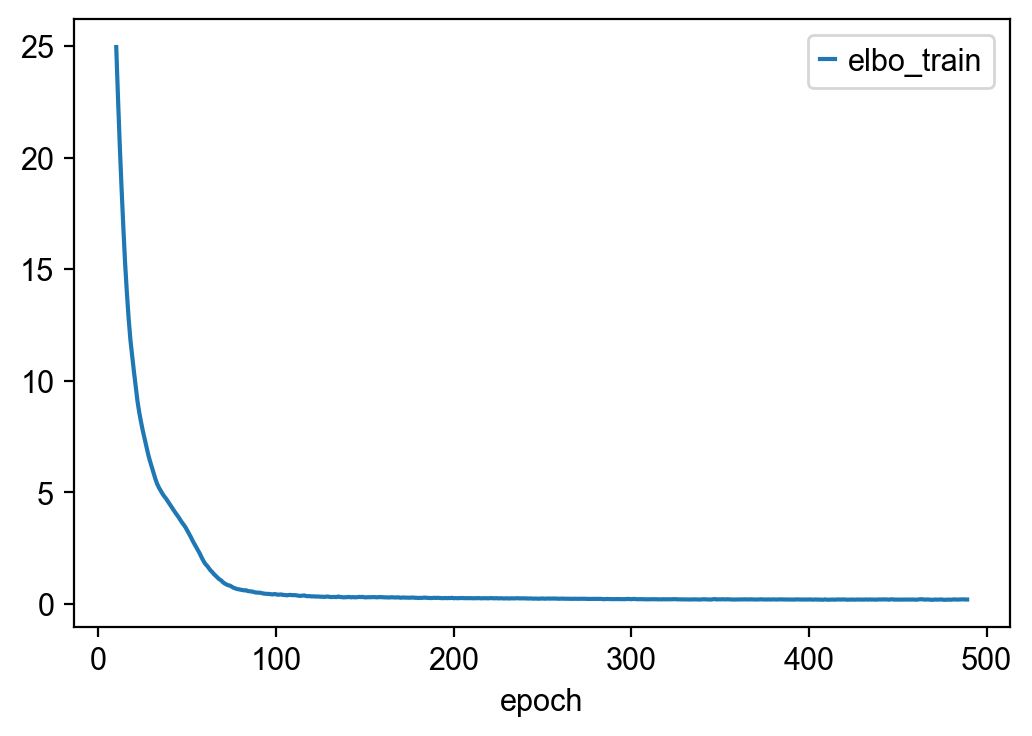

In [266]:
fig, ax = plt.subplots()
reg_vae.history["elbo_train"].iloc[10:].plot(ax=ax, label="train_loss_epoch")
plt.legend()

In [267]:
reg_vae.module.lamba

10

In [268]:
reg_vae.module.lamba

10

In [285]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(486.2224, grad_fn=<AddBackward0>)

In [286]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [287]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


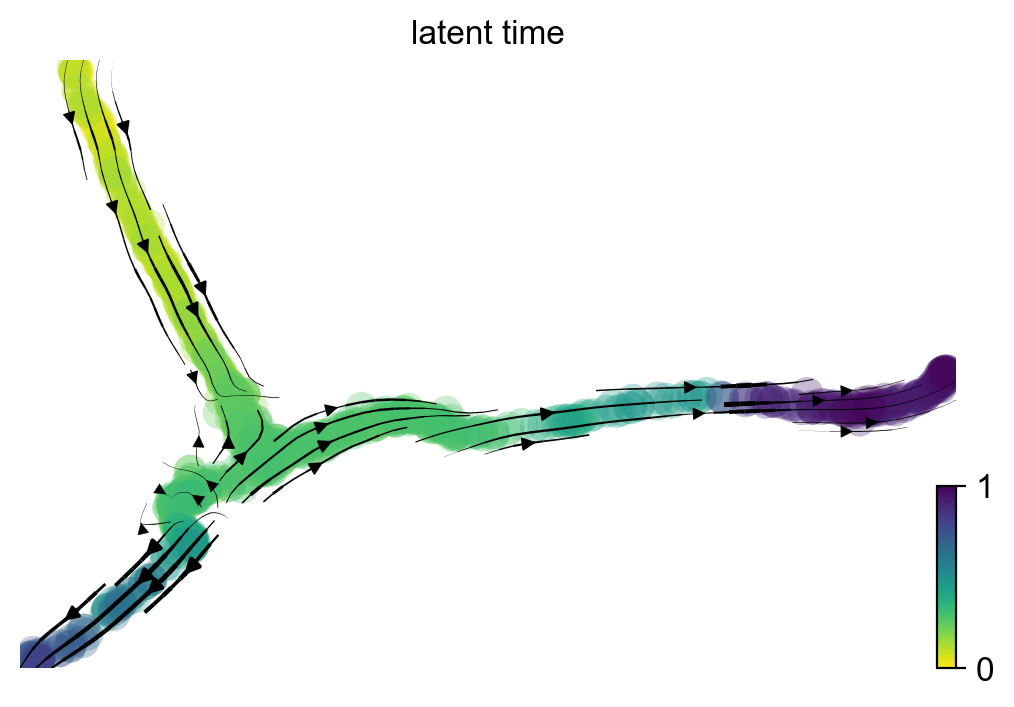

In [288]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [289]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.8560405586480535, pvalue=2.861497126466942e-288)

In [290]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [291]:
adata_target.layers["rna_velocity"].max()

9.66399654745004

In [292]:
corr.mean()

0.17618494949860158

In [293]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [294]:
W

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [295]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()
GRN = W.T * reg_vae.module.v_encoder.grn
#GRN_0 = W.T * reg_vae_0.module.v_encoder.grn
#GRN_0_0001 = W.T * reg_vae_0_0001.module.v_encoder.grn
#GRN_0_001 = W.T * reg_vae_0_001.module.v_encoder.grn
#GRN_0_01 = W.T * reg_vae_0_01.module.v_encoder.grn
#GRN_0_1 = W.T * reg_vae_0_1.module.v_encoder.grn

In [296]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [297]:
pre = GRN[W.T==1]
#pre_0 = GRN_0[W.T==1]
#pre_0_0001 = GRN_0_0001[W.T==1]
#pre_0_001 = GRN_0_001[W.T==1]
#pre_0_01 = GRN_0_01[W.T==1]
#pre_0_1 = GRN_0_1[W.T==1]

In [298]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [299]:
corr_m[corr_m==1] = 0

In [300]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [301]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

-0.05438800923419008

In [302]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.545591780528426

In [303]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(corr_m.ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.7888155828626415

In [173]:
### run VeloVAE
import sys
sys.path.append("/Users/weixu.wang/Documents/pj/RegVelo/RegVelo/VeloVAE")
import velovae as vv

In [503]:
vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cpu')

Estimating ODE parameters...


  0%|          | 0/141 [00:00<?, ?it/s]

Detected 89 velocity genes.
Estimating the variance...


  0%|          | 0/141 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/141 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.37, 0.7836147447522841), (0.63, 0.2951635812621893)
(0.55, 0.8431695085869744), (0.45, 0.324509484925456)
KS-test result: [1. 0. 0.]
Initial induction: 84, repression: 57/141


In [504]:
config = {
    # You can change any hyperparameters here!
}
vae.train(adata,
          config=config,
          plot=False,
          embed='dimred')

Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.028
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1434.    *********
Change in noise variance: 0.0336
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1491.    *********
Change in noise variance: 0.0084
Change in x0: 0.4721
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1500.    *********
Change in noise variance: 0.0041
Change in x0: 0.3273
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1626.    *********
Change in noise variance: 0.0041
Change in x0: 0.2096
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1723.    *********
Change in noise variance: 0.0006
Change in x0: 0.1901
*********             Velocity Refinement Round 

In [505]:
vae.save_anndata(adata, 'vae', "/Users/weixu.wang/Documents/pj/RegVelo/RegVelo-analysis", file_name="pancreas_out.h5ad")

In [489]:
torch.manual_seed(2022)
np.random.seed(2022)
rate_prior = {
    'alpha': (0.0, 1.0),
    'beta': (0.0, 0.5),
    'gamma': (0.0, 0.5)
}
full_vb = vv.VAE(adata, 
                 tmax=20, 
                 dim_z=5, 
                 device='cpu',
                 full_vb=True,
                 rate_prior=rate_prior)

Estimating ODE parameters...


  0%|          | 0/141 [00:00<?, ?it/s]

Detected 89 velocity genes.
Estimating the variance...


  0%|          | 0/141 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/141 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.40, 0.7794799156599237), (0.60, 0.2716483253552967)
(0.61, 0.8342811718769557), (0.39, 0.2643999867002183)
KS-test result: [1. 0. 0.]
Initial induction: 90, repression: 51/141


In [490]:
config = {
    # You can change any hyperparameters here!
}
full_vb.train(adata,
          config=config,
          plot=False,
          embed='dimred')

Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.028
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1294.    *********
Change in noise variance: 0.0392
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1338.    *********
Change in noise variance: 0.0328
Change in x0: 0.5960
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1440.    *********
Change in noise variance: 0.0046
Change in x0: 0.3849
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1447.    *********
Change in noise variance: 0.0030
Change in x0: 0.2971
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1454.    *********
Change in noise variance: 0.0010
Change in x0: 0.2326
*********             Velocity Refinement Round 

In [483]:
del adata.layers["velocity"]

In [495]:
full_vb.save_anndata(adata, 'fullvb', "/Users/weixu.wang/Documents/pj/RegVelo/RegVelo-analysis", file_name="pancreas_out.h5ad")

In [509]:
adata.layers["velocity"] = adata.layers["vae_velocity"].copy()

In [510]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


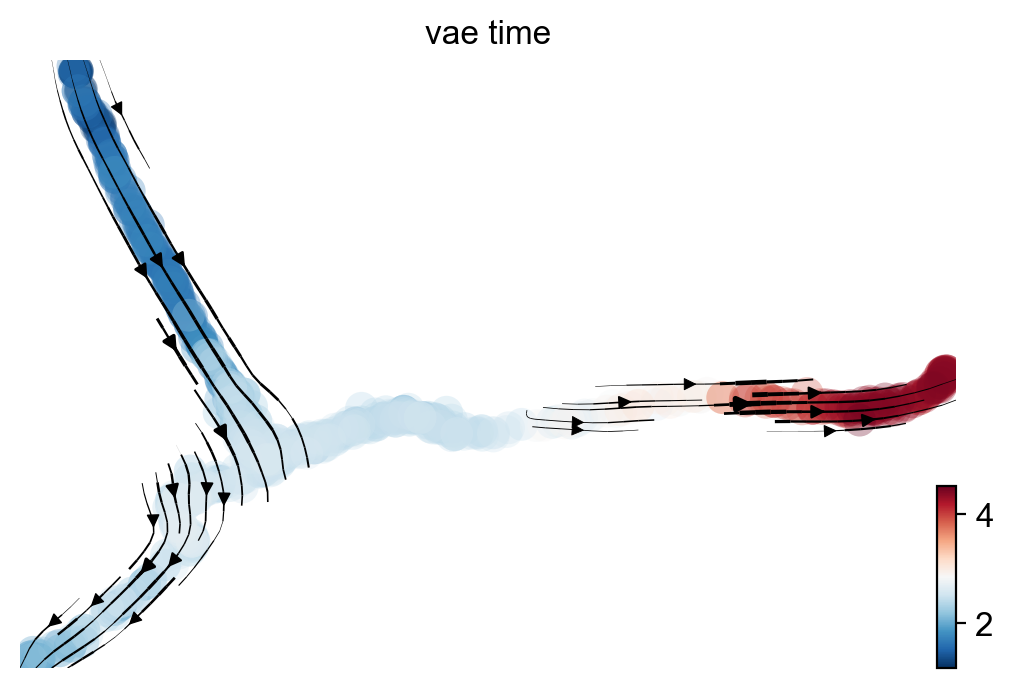

In [512]:
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'vae_time')

In [515]:
import scipy
scipy.stats.spearmanr(adata.obs["fullvb_time"], adata.obs["sim_time"])

SignificanceResult(statistic=0.57254098537692, pvalue=3.6669393255876333e-88)

In [507]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["vae_velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:141,141:(141*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [508]:
corr.mean()

0.17288023270562686

In [506]:
adata

AnnData object with n_obs × n_vars = 1000 × 141
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'fullvb_time', 'fullvb_std_t', 'fullvb_t0', 'vae_time', 'vae_std_t', 'vae_t0'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'init_mode', 'w_init', 'fullvb_logmu_alpha', 'fullvb_logmu_beta', 'fullvb_logmu_gamma', 'fullvb_logstd_alpha', 'fullvb_logstd_beta', 'fullvb_logstd_gamma', 'fullvb_ton', 'fullvb_scaling', 'fullvb_sigma_u', 'fullvb_sigma_s', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s'
    uns: 'network', 'regul

In [ ]:
d = {'Pearson_Correlation': [0.14904173963968984,
              0.1591490775575371,
              0.16574673382966143, 
              0.15867883817250994,
              0.18934842357315437],
     'Model': ["Random Graph(#edges = 127)",
               "Random Graph(#edges = 348)",
               "Random Graph(#edges = 569)",
               "Random Graph(#edges = 1197)",
               "Truth Graph(#edges = 386)"]}
df = pd.DataFrame(data=d)

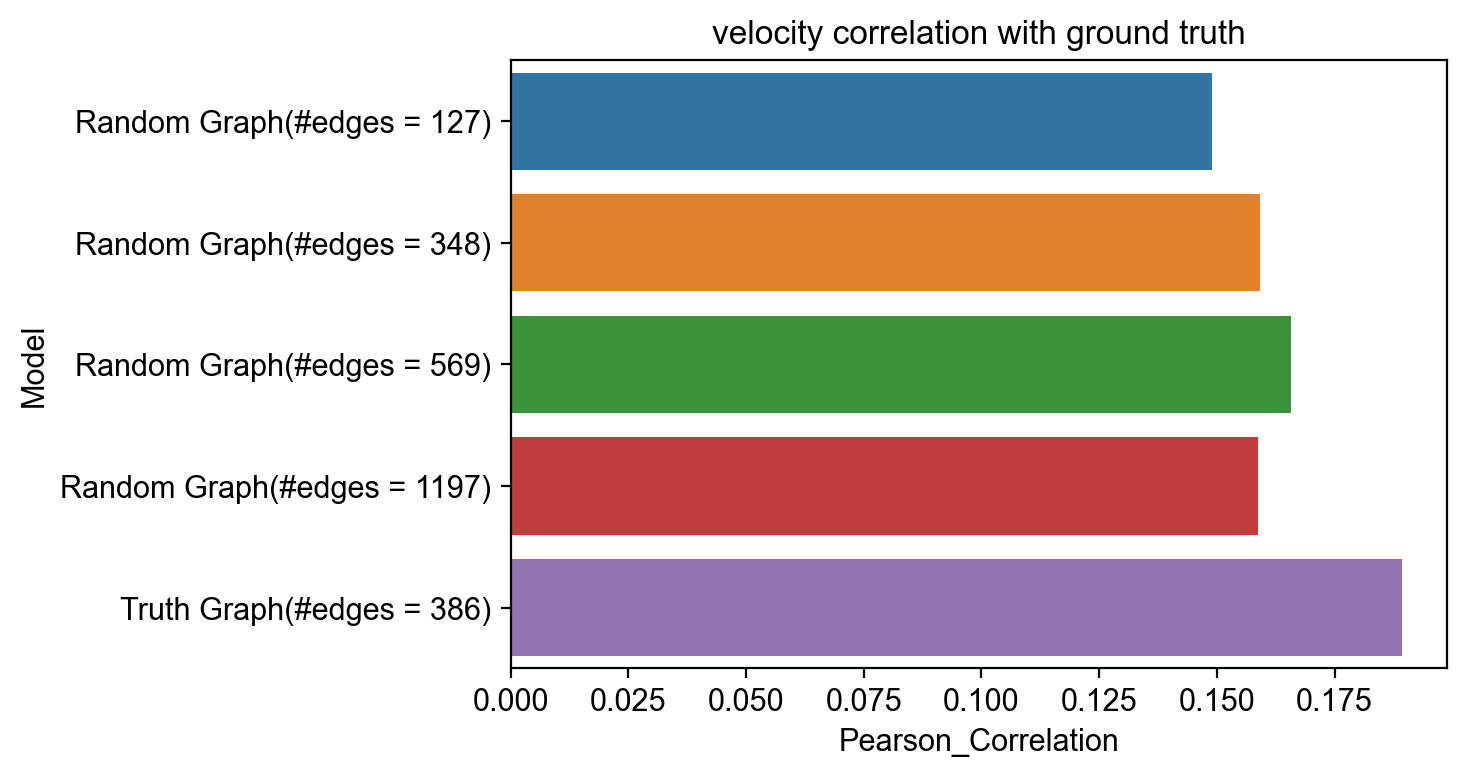

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Pearson_Correlation",data=df).set(title='velocity correlation with ground truth')  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [ ]:
d = {'Spearman_Correlation': [0.8051733290648203,
              0.8146423838660012,
              0.8123833769354999, 
              0.8032826981565722,
              0.8525169530437499],
     'Model': ["Random Graph(#edges = 127)",
               "Random Graph(#edges = 348)",
               "Random Graph(#edges = 569)",
               "Random Graph(#edges = 1197)",
               "Truth Graph(#edges = 386)"]}
df = pd.DataFrame(data=d)

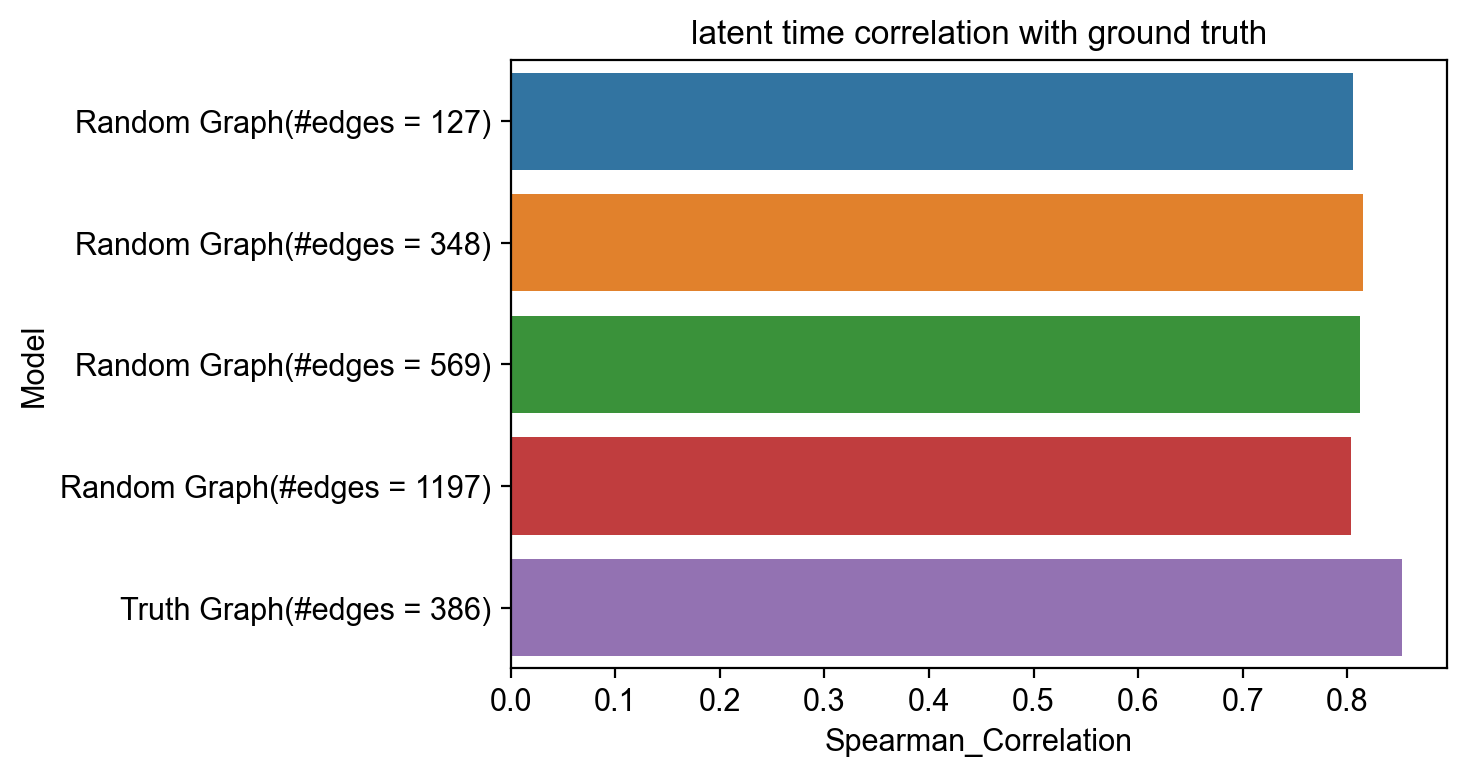

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Spearman_Correlation",data=df).set(title='latent time correlation with ground truth')  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [ ]:
attr_dict, var_names, load_state_dict = _get_loaded_data(
    reg_vae, device="cpu"
)

In [ ]:
load_state_dict

OrderedDict([('switch_time_unconstr',
              tensor([ 8.9398,  6.4609, 11.2575,  7.7566,  7.7635,  6.8689,  8.1414,  7.5435,
                       8.0200,  7.6247,  7.7495,  8.1416,  7.2177,  7.8939,  8.6356,  6.0436,
                       7.9499,  8.7684,  8.3530,  8.0275,  7.8365,  8.7751,  7.0371,  8.0674,
                       8.5438,  7.7309,  7.6088,  8.0650,  8.1708,  8.0333,  8.0339,  7.6098,
                       7.5841,  6.3420,  7.3274,  7.0161,  7.0675,  7.4437,  6.3061,  7.7626,
                       8.0422,  8.0000,  7.8392,  7.6489,  6.5385,  6.7724,  7.2385,  8.9053,
                       7.1533,  7.1836,  6.6775,  7.2884,  7.0611,  6.4471,  8.1119,  7.3859,
                       7.4779,  7.7664,  8.0718,  7.9246,  8.5361,  7.5816,  7.5794,  7.3672,
                       6.9416,  7.5094,  8.3393,  9.0959,  8.1998,  7.9375,  7.6360,  7.9355,
                       7.8296,  8.7931,  8.1676,  8.1099,  7.8992,  7.8448,  7.7469,  6.7008,
                      

In [35]:
registry = attr_dict.pop("registry_")

In [36]:
registry

{'scvi_version': '0.20.3',
 'model_name': 'REGVELOVI',
 'setup_args': {'spliced_layer': 'Ms', 'unspliced_layer': 'Mu'},
 'field_registries': defaultdict(dict,
             {'X': {'data_registry': {'attr_name': 'layers', 'attr_key': 'Ms'},
               'state_registry': {'n_obs': 1000,
                'n_vars': 141,
                'column_names': array(['A3_TF3', 'A3_TF4', 'A3_TF5', 'A3_TF6', 'A4_TF1', 'A4_TF3',
                       'A5_TF1', 'A5_TF2', 'A6_TF1', 'A6_TF2', 'A6_TF3', 'A6_TF4',
                       'B10_TF1', 'B10_TF2', 'B11_TF1', 'B11_TF2', 'B11_TF3', 'B11_TF4',
                       'B11_TF5', 'B11_TF6', 'B11_TF7', 'B11_TF8', 'B12_TF1', 'B12_TF2',
                       'B12_TF3', 'B12_TF4', 'B13_TF1', 'B13_TF2', 'B13_TF3', 'B13_TF4',
                       'B14_TF1', 'B14_TF2', 'B14_TF3', 'B14_TF4', 'B14_TF5', 'B14_TF6',
                       'B1_TF1', 'B1_TF2', 'B1_TF3', 'B2_TF1', 'B2_TF2', 'B2_TF3',
                       'B2_TF4', 'B2_TF5', 'B3_TF1', 'B3_TF2

In [40]:
REGVELOVI.setup_anndata(
    adata,
    source_registry=registry,
    extend_categories=True,
    allow_missing_labels=True,
    **registry[_SETUP_ARGS_KEY],
)

In [41]:
model = _initialize_model(REGVELOVI, adata, attr_dict)

In [48]:
adata_manager = model.get_anndata_manager(adata, required=True)

In [49]:
adata_manager

In [50]:
model.to_device("cpu")

In [51]:
model

REGVELOVI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained
Model's adata is minified?: False

In [52]:
model.module.load_state_dict(load_state_dict)
model.module.eval()

VELOVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=282, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=256, out_features=10, bias=True)
    (var_encoder): Linear(in_features=256, out_features=10, bias=True)
    (var_activation): Softplus(beta=1, threshold=20)
  )
  (decoder): DecoderVELOVI(
    (rho_first_decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): LayerNorm((256,), eps=1e-05, elementwise_affine=Fa

In [55]:
model.module.v_encoder.grn

Parameter containing:
tensor([[-0.6130, -0.0000, -0.5618,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.5641,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [57]:
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[-0.6130, -0.0000, -0.5618,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.5641,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [59]:
for key, module in model.module.named_modules():
    print(key)


z_encoder
z_encoder.encoder
z_encoder.encoder.fc_layers
z_encoder.encoder.fc_layers.Layer 0
z_encoder.encoder.fc_layers.Layer 0.0
z_encoder.encoder.fc_layers.Layer 0.1
z_encoder.encoder.fc_layers.Layer 0.2
z_encoder.encoder.fc_layers.Layer 0.3
z_encoder.encoder.fc_layers.Layer 0.4
z_encoder.mean_encoder
z_encoder.var_encoder
z_encoder.var_activation
decoder
decoder.rho_first_decoder
decoder.rho_first_decoder.fc_layers
decoder.rho_first_decoder.fc_layers.Layer 0
decoder.rho_first_decoder.fc_layers.Layer 0.0
decoder.rho_first_decoder.fc_layers.Layer 0.1
decoder.rho_first_decoder.fc_layers.Layer 0.2
decoder.rho_first_decoder.fc_layers.Layer 0.3
decoder.pi_first_decoder
decoder.pi_first_decoder.fc_layers
decoder.pi_first_decoder.fc_layers.Layer 0
decoder.pi_first_decoder.fc_layers.Layer 0.0
decoder.pi_first_decoder.fc_layers.Layer 0.1
decoder.pi_first_decoder.fc_layers.Layer 0.2
decoder.pi_first_decoder.fc_layers.Layer 0.3
decoder.px_pi_decoder
decoder.px_rho_decoder
decoder.px_rho_decode

In [69]:
model.module.v_encoder.alpha_unconstr_max.requires_grad = False

In [72]:
model.module.alpha_1_unconstr

Parameter containing:
tensor([ 7.7201e-01,  7.4656e-01,  7.3443e+00,  1.1697e+00,  7.8019e-01,
         8.1512e-01,  7.6706e-01, -3.2856e-02, -3.0120e-01, -1.9026e-01,
        -1.0876e-01, -3.8542e-01, -1.2478e-01, -2.1542e-01, -3.1703e-01,
        -2.4870e-02, -2.8895e-01,  1.5112e-01,  5.3563e-02,  3.5352e-02,
         2.0295e-01, -4.3566e-02, -9.8782e-03,  8.9033e-02,  1.2160e-01,
         1.4023e-01,  9.8497e-02,  9.0283e-04,  2.5853e-02,  2.4728e-03,
         2.4231e-01, -2.7291e-01, -4.8460e-01, -2.9011e-01, -2.7224e-01,
        -3.7713e-01, -1.7269e-01, -2.6194e-01, -3.7253e-01, -1.2894e-01,
        -1.9565e-01, -2.3994e-01, -1.1557e-01,  7.7277e-02,  9.0973e-01,
         8.4561e-01,  7.7572e-01,  9.5791e-01,  7.2679e-01,  8.4865e-01,
         7.3950e-01,  7.2508e-01, -4.1268e-01, -1.2878e-01, -6.8774e-04,
        -1.5857e-01, -2.5178e-01, -8.0920e-02, -2.5074e-01, -3.4813e-01,
         7.1401e-02, -9.3651e-02, -1.5113e-01,  1.0255e-02, -8.3609e-02,
         3.8103e-02, -2.3463e

In [74]:
model.module.v_encoder.grn.requires_grad

True

In [78]:
for k,par in model.module.v_encoder.named_parameters():
    print(k)

log_h
log_phi
tau
o
grn
beta_mean_unconstr
gamma_mean_unconstr
alpha_unconstr_max
alpha_unconstr_bias


In [88]:
model_stage = "sdas"
if model_stage == "pretraining":
    print('elbo_train')
elif model_stage == "refining":
    print("loss")
else:
    raise ValueError("Seems model is not in pretraining or refining")

ValueError: Seems model is not in pretraining or refining

In [89]:
attr_dict

{'history_': {'validation_loss':       validation_loss
  epoch                
  0           83.795418
  1            18.71455
  2            1.632535
  3          -13.104841
  4          -20.945612
  ...               ...
  162       -458.038177
  163       -469.001709
  164       -463.427734
  165       -455.971863
  166       -455.627808
  
  [167 rows x 1 columns],
  'elbo_validation':       elbo_validation
  epoch                
  0            7.054896
  1            6.789626
  2            7.637541
  3            6.809509
  4            6.801549
  ...               ...
  162          2.734669
  163          2.735562
  164          2.704306
  165          2.924189
  166          2.890836
  
  [167 rows x 1 columns],
  'reconstruction_loss_validation':       reconstruction_loss_validation
  epoch                               
  0                           7.054896
  1                           6.789626
  2                           7.637541
  3                           6.809509
